<a href="https://colab.research.google.com/github/rehgend/EksplorasiDeepFace/blob/main/Pengenalan%20Wajah%20Anggota%20Kelas%20dengan%20DeepFace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **<center>Pengenalan Wajah Anggota Kelas dengan DeepFace**
### **<center>Rahman Indra Kesuma - 33221026**
### **<center>Handoko Supeno - 33220026**
<br><br>


## **Tahapan 1. Persiapan Library**
Memuat library yang dibutuhkan dalam pemrosesan data hingga proses pengenalan wajah dari suatu data citra apakah termasuk anggota kelas Pembelajaran Mesin Lanjut (Semester Genap T.A. 2021/2022) STEI ITB atau bukan.

In [ ]:
# Library untuk pengaksesan media penyimpanan
import os
import shutil
import numpy as np
from google.colab import drive

# Library untuk persiapan data image
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

# Library untuk pemrosesan data image untuk data augmentation
import random
from scipy import ndarray
import skimage as sk
from skimage import transform
from skimage import img_as_ubyte
from skimage import util
from skimage import io
from skimage import exposure

# Library yang digunakan untuk memanfaatkan fasilitas DeepFace
!pip install deepface
from deepface import DeepFace
from scipy import stats

# Library untuk mengukur kualitas model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score

# Library untuk melakukan plotting
import matplotlib.pyplot as plt


## **Tahapan 2. Data Loading**
Memuat data wajah dari anggota kelas yang sudah dipersiapkan dan disimpan pada google drive.

In [ ]:
# Memastikan bahwa belum ada folder dan membuat folder baru untuk 
# menyimpan data citra wajah anggota kelas
!rm -rf '/content/db_wajah_anggota'
os.mkdir("/content/db_wajah_anggota/")

In [ ]:
# Proses memindahkan data citra wajah anggota kelas ke dalam folder yang telah disiapkan
list_label = []
drive.mount('/content/drive')
path_db = '/content/drive/MyDrive/Eksplorasi Machine Learning/Tugas Deep Learning ITB (Face Recognition)/DB Wajah Anggota Kelas/'
for path, subdirs, files in os.walk(path_db):
  for name in files:
    sourcepath_file = path_db+name
    destpath_file = '/content/db_wajah_anggota/'+name
    shutil.copyfile(sourcepath_file, destpath_file)

    temp = name.split(".")
    list_label.append(temp[0])

list_label.append("Non Anggota Kelas")
list_label.sort()

Mounted at /content/drive



## **Tahapan 3. Data Augmentation**
Memproses satu gambar wajah dari suatu anggota kelas untuk dibentuk data citra yang memberikan varian informasi seperti perbedaan rotasi, noise, dan lainnya.

In [ ]:
# Pendefinisian beberapa fungsi transformasi data image

def random_rotation(image_array: ndarray):
  # Mengambil secara random derajat rotasi antara 25% pada kiri dan 25% pada kanan
  random_degree = random.uniform(-25, 25)
  return transform.rotate(image_array, random_degree)

def random_noise(image_array: ndarray):
  # Menambahkan noise pada data image
  return util.random_noise(image_array)

def horizontal_flip(image_array: ndarray):
  # Proses hanya melakukan flip data array dari pixel image 
  return image_array[:, ::-1]

def brightness_change(image_array: ndarray):
  # Proses pengubahan brightness dengan menggunakan pengaturan nilai gamma
  gain = np.random.uniform(0.25, 1)
  gamma = np.random.uniform(0.25, 1)
  return exposure.adjust_gamma(image_array, gamma, gain)

In [ ]:
# Memastikan bahwa belum ada folder untuk menyimpan data augmentation dan membuat folder baru
!rm -rf '/content/db_aug_proses'
os.mkdir("/content/db_aug_proses/")

In [ ]:
# Proses pembuatan data sintetis sebanyak lima dengan varian rotasi, noise, flip horizontal, dan tingkat brightness
banyak_data_augmentation = 5

path_db = '/content/drive/MyDrive/Eksplorasi Machine Learning/Tugas Deep Learning ITB (Face Recognition)/DB Wajah Anggota Kelas/'
for path, subdirs, files in os.walk(path_db):
  for name in files:
    nama_anggota = name.split(".")
    path_save = "/content/db_aug_proses/"+nama_anggota[0]+"-"
    image_path = path_db+name
    image_to_transform = io.imread(image_path)

    for i in range(0, banyak_data_augmentation):
      transformed_image = random_rotation(image_to_transform)
      if (random.uniform(0, 1) > 0.5):
        transformed_image = random_noise(transformed_image)
      if (random.uniform(0, 1) > 0.5):
        transformed_image = horizontal_flip(transformed_image)
      if (random.uniform(0, 1) > 0.5):
        transformed_image = brightness_change(transformed_image)
      
      file_name = "DataAug%s.jpg" % (i)
      new_file = path_save + file_name
      io.imsave(new_file,img_as_ubyte(transformed_image))
    
    file_name = "DataAug%s.jpg" % (i+1)
    new_file = path_save + file_name
    image_dasar = io.imread(image_path)
    io.imsave(new_file,img_as_ubyte(image_dasar))


## **Tahapan 4. Pemastian Basisdata Wajah Anggota**
Proses untuk memasukkan keseluruhan data, baik data asli dan data augmentasi ke dalam variabel numpy dan ditampilkan beberapa data secara random, sebelum siap digunakan untuk proses pengenalan wajah dengan DeepFace

In [ ]:
# Mengambil data citra dari folder hasil augmentasi serta menyamakan dimensi
# data menjadi 120x100 dan dimasukkan ke variabel numpy

db_wajah_anggota = np.empty([1, 120, 100, 3])
db_nama_anggota = ['None']

path_folder = '/content/db_aug_proses/'
for path, subdirs, files in os.walk(path_folder):
  for namefile in files:
    sourcepath_file = path_folder+namefile
    image = load_img(sourcepath_file, target_size=(120, 100))
    array_image = img_to_array(image)
    array_image = array_image.reshape(1, array_image.shape[0], array_image.shape[1], array_image.shape[2])
    db_wajah_anggota = np.append(db_wajah_anggota, array_image, axis=0)
    
    nama_anggota = namefile.split("-")
    db_nama_anggota.append(nama_anggota[0])

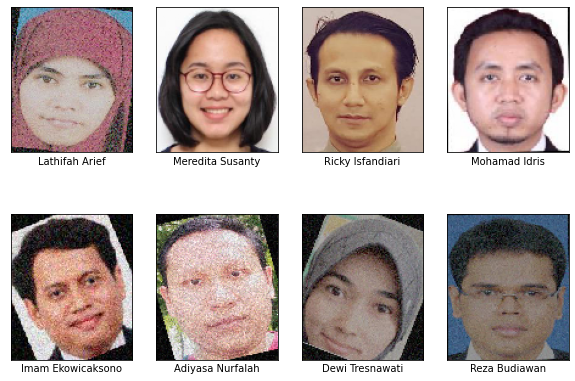

In [ ]:
# Memastikan data telah berhasil termuat dan tersimpan pada variabel numpy
db_wajah_anggota_process = (np.expand_dims(db_wajah_anggota, axis=-1)/255.).astype(np.float32)

plt.figure(figsize=(10,7))
random_inds = np.random.choice(len(db_nama_anggota),8)
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_ind = random_inds[i]
    plt.imshow(np.squeeze(db_wajah_anggota_process[image_ind]), cmap=plt.cm.binary)
    plt.xlabel(db_nama_anggota[image_ind])


## **Tahapan 5. Persiapan Dataset untuk Pengujian Model**
Proses untuk memasukkan keseluruhan test set yang telah disiapkan di media penyimpanan google drive ke dalam folder yang disediakan. Yang mana, nantinya folder tersebut akan digunakan untuk proses pengujian model pengenalan wajah dengan DeepFace.

In [ ]:
# Memastikan bahwa belum ada folder dan membuat folder baru untuk 
# menyimpan data citra wajah untuk proses pengujian model
!rm -rf '/content/db_wajah_test'
os.mkdir("/content/db_wajah_test/")

In [ ]:
# Proses memindahkan test set (data citra) ke dalam folder yang telah disiapkan
drive.mount('/content/drive')
path_db = '/content/drive/MyDrive/Eksplorasi Machine Learning/Tugas Deep Learning ITB (Face Recognition)/Testing Data/'
for path, subdirs, files in os.walk(path_db):
  for name in files:
    sourcepath_file = path_db+name
    destpath_file = '/content/db_wajah_test/'+name
    shutil.copyfile(sourcepath_file, destpath_file)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Deskripsi dari jumlah data pada Database Wajah Anggota Kelas dan Data Testing
jumData_Wajah_Anggota = 0
jumData_Testing_Anggota = 0
jumData_Testing_NonAnggota = 0

path_db = '/content/db_wajah_anggota'
for path, subdirs, files in os.walk(path_db):
  for name in files :
    jumData_Wajah_Anggota = jumData_Wajah_Anggota + 1

path_db = '/content/db_wajah_test'
for path, subdirs, files in os.walk(path_db):
  for name in files :
    subname = name.split("-")
    if subname[1] == 'AA' :
      jumData_Testing_Anggota = jumData_Testing_Anggota + 1
    else :
      jumData_Testing_NonAnggota = jumData_Testing_NonAnggota + 1

print("Jumlah Database Wajah Anggota Kelas -> ", jumData_Wajah_Anggota)
print("Jumlah Data Testing - Anggota Kelas -> ", jumData_Testing_Anggota)
print("Jumlah Data Testing - Non Anggota Kelas -> ", jumData_Testing_NonAnggota)

Jumlah Database Wajah Anggota Kelas ->  28
Jumlah Data Testing - Anggota Kelas ->  49
Jumlah Data Testing - Non Anggota Kelas ->  49



## **Tahapan 6. Percobaan Library DeepFace**
Proses percobaan untuk penggunaan library deepface dengan default setting untuk tujuan pengenalan wajah dalam test set ke database wajah hasil augmentation.

In [ ]:
test_image = "/content/db_wajah_test/D01-NA-Airin Rachmi Diany.jpg"
hasil_deepface = DeepFace.find(img_path = test_image, db_path = "/content/db_aug_proses", enforce_detection=False, prog_bar=True)


There are  168  representations found in  representations_vgg_face.pkl
find function lasts  1.6698815822601318  seconds


Daftar Data Wajah yang Dianggap Memiliki Kemiripan


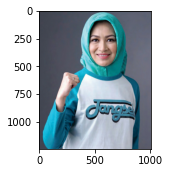

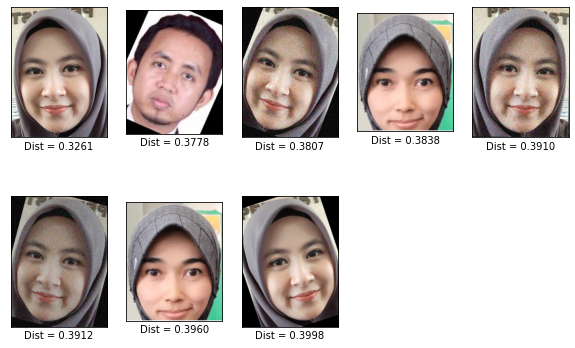

In [ ]:
print("Daftar Data Wajah yang Dianggap Memiliki Kemiripan")

data_wajah_test = io.imread(test_image)
plot_wajah_test = (np.expand_dims(data_wajah_test, axis=-1)/255.).astype(np.float32)
plt.figure(figsize=(2,4))
plt.imshow(np.squeeze(plot_wajah_test), cmap=plt.cm.binary)

if hasil_deepface['identity'].count() > 0:
  index = 1
  lebar = hasil_deepface['identity'].count() / 5
  plt.figure(figsize=(10,4*lebar))
  for hasil_path,dist_value in zip(hasil_deepface.iloc[:, 0],hasil_deepface.iloc[:, 1]) :
    data_wajah_hasil = io.imread(hasil_path)
    plot_wajah_hasil = (np.expand_dims(data_wajah_hasil, axis=-1)/255.).astype(np.float32)
    plt.subplot(lebar+1,5,index)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.squeeze(plot_wajah_hasil), cmap=plt.cm.binary)
    plt.xlabel("Dist = {:.4f}".format(dist_value))
    index = index + 1
else :
  print("Tidak ada wajah yang dianggap mirip dengan Database Anggota Kelas")

In [ ]:
# Pengecekan label Anggota Kelas (Nama Anggota) dan Non Anggota Kelas dengan menggunakan
# threshold dari nilai distance sebesar 0.2

dist_threshold = 0.2
label_find = []
for hasil_path,dist_value in zip(hasil_deepface.iloc[:, 0],hasil_deepface.iloc[:, 1]) :
  if dist_value < dist_threshold :
    nama_file = hasil_path.split("/")
    nama_anggota = nama_file[3].split("-")
    label_find.append(nama_anggota[0])
print(label_find)

if len(label_find) > 0 :
  label_final = stats.mode(label_find)[0][0]
else :
  label_final = "Non Anggota Kelas"

nama_file_actual = test_image.split("/")
nama_anggota_actual = nama_file_actual[3].split("-")
if nama_anggota_actual[1] == "AA" :
  temp = nama_anggota_actual[2].split(".")
  label_actual = temp[0]
else :
  label_actual = "Non Anggota Kelas"

print("\nActual Label : ", label_actual)
print("Predicted Label : ", label_final)

[]

Actual Label :  Non Anggota Kelas
Predicted Label :  Non Anggota Kelas



## **Tahapan 7. Persiapan Eksperimen dengan DeepFace**
Proses pendefinisian beberapa fungsi yang nantinya akan digunakan untuk proses eksplorasi dan pencarian setting model terbaik untuk pengenalan wajah dari anggota kelas.

In [ ]:
# Fungsi eksplorasi didesain untuk mencari setting dari model_name, distance_metric, dan detector_backend terbaik
def deepface_apply(nama_model, matriks_jarak, detector):
  hasil_eksperimen = []
  label_actual = []
  label_predict = []

  path_db = '/content/db_wajah_test/'
  for path, subdirs, files in os.walk(path_db):
    for name in files :
      test_image = path_db+name
      hasil_deepface = DeepFace.find(img_path = test_image, db_path = "/content/db_aug_proses", enforce_detection=False, prog_bar=True, model_name=nama_model, distance_metric=matriks_jarak, detector_backend=detector)

      dist_threshold = 0.2
      label_find = []
      for hasil_path,dist_value in zip(hasil_deepface.iloc[:, 0],hasil_deepface.iloc[:, 1]) :
        if dist_value < dist_threshold :
          nama_file = hasil_path.split("/")
          nama_anggota = nama_file[3].split("-")
          label_find.append(nama_anggota[0])

      if len(label_find) > 0 :
        label_predict.append(stats.mode(label_find)[0][0])
      else :
        label_predict.append("Non Anggota Kelas")

      nama_file_actual = test_image.split("/")
      nama_anggota_actual = nama_file_actual[3].split("-")
      if nama_anggota_actual[1] == "AA" :
        temp = nama_anggota_actual[2].split(".")
        label_actual.append(temp[0])
      else :
        label_actual.append("Non Anggota Kelas")
  
  hasil_eksperimen.append(confusion_matrix(label_actual, label_predict, labels=list_label))
  hasil_eksperimen.append(accuracy_score(label_actual, label_predict))
  hasil_eksperimen.append(f1_score(label_actual, label_predict, average='macro')) 
  return hasil_eksperimen

In [ ]:
hasil = deepface_apply("Facenet512", "cosine", "opencv")
print("\nAkurasi : {:.4f}".format(hasil[1]))
print("Macro F1-Score : {:.4f}".format(hasil[2]))

facenet512_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facenet512_weights.h5
To: /root/.deepface/weights/facenet512_weights.h5
100%|██████████| 95.0M/95.0M [00:23<00:00, 4.03MB/s]


Representations stored in  /content/db_aug_proses / representations_facenet512.pkl  file. Please delete this file when you add new identities in your database.
find function lasts  70.95829033851624  seconds
There are  168  representations found in  representations_facenet512.pkl
find function lasts  1.5218701362609863  seconds
There are  168  representations found in  representations_facenet512.pkl
find function lasts  0.43720102310180664  seconds
There are  168  representations found in  representations_facenet512.pkl
find function lasts  0.34627294540405273  seconds
There are  168  representations found in  representations_facenet512.pkl
find function lasts  0.2552638053894043  seconds
There are  168  representations found in  representations_facenet512.pkl
find function lasts  0.2672615051269531  seconds
There are  168  representations found in  representations_facenet512.pkl
find function lasts  0.3201756477355957  seconds
There are  168  representations found in  representations_


## **Tahapan 8. Percobaan Pertama dari Strategi Eksperimen dengan DeepFace**
Proses percobaan pertama dilakukan dengan fokus pencarian model terbaik yang bisa digunakan dalam arsitektur DeepFace. Yang mana berdasarkan panduan penggunaan library DeepFace terdapat beberapa state-of-the-art dari model pengenalan wajah seperti VGG-Face, Google FaceNet, OpenFace, Facebook DeepFace, DeepID, ArcFace dan Dlib.

In [ ]:
# Setting distance_metric : cosine
# Setting detector_backend : opencv
list_models = ["VGG-Face", "Facenet", "Facenet512", "OpenFace", "DeepFace", "DeepID", "ArcFace", "Dlib"]
hasil_recognition = []

for nama_model in list_models:
  hasil = deepface_apply(nama_model, "cosine", "opencv")
  hasil_recognition.append(hasil)

There are  168  representations found in  representations_vgg_face.pkl
find function lasts  0.5533370971679688  seconds
There are  168  representations found in  representations_vgg_face.pkl
find function lasts  1.7536063194274902  seconds
There are  168  representations found in  representations_vgg_face.pkl
find function lasts  0.7234628200531006  seconds
There are  168  representations found in  representations_vgg_face.pkl
find function lasts  0.5973200798034668  seconds
There are  168  representations found in  representations_vgg_face.pkl
find function lasts  0.485975980758667  seconds
There are  168  representations found in  representations_vgg_face.pkl
find function lasts  0.483323335647583  seconds
There are  168  representations found in  representations_vgg_face.pkl
find function lasts  0.5687544345855713  seconds
There are  168  representations found in  representations_vgg_face.pkl
find function lasts  0.8621819019317627  seconds
There are  168  representations found in  

Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facenet_weights.h5
To: /root/.deepface/weights/facenet_weights.h5
100%|██████████| 92.2M/92.2M [00:13<00:00, 6.86MB/s]


Representations stored in  /content/db_aug_proses / representations_facenet.pkl  file. Please delete this file when you add new identities in your database.
find function lasts  59.58088946342468  seconds
There are  168  representations found in  representations_facenet.pkl
find function lasts  1.4321939945220947  seconds
There are  168  representations found in  representations_facenet.pkl
find function lasts  0.4107658863067627  seconds
There are  168  representations found in  representations_facenet.pkl
find function lasts  0.31347203254699707  seconds
There are  168  representations found in  representations_facenet.pkl
find function lasts  0.21988439559936523  seconds
There are  168  representations found in  representations_facenet.pkl
find function lasts  0.23965764045715332  seconds
There are  168  representations found in  representations_facenet.pkl
find function lasts  0.2672584056854248  seconds
There are  168  representations found in  representations_facenet.pkl
find fun

Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/openface_weights.h5
To: /root/.deepface/weights/openface_weights.h5
100%|██████████| 15.3M/15.3M [00:01<00:00, 14.8MB/s]


Representations stored in  /content/db_aug_proses / representations_openface.pkl  file. Please delete this file when you add new identities in your database.
find function lasts  41.345378160476685  seconds
There are  168  representations found in  representations_openface.pkl
find function lasts  1.402848243713379  seconds
There are  168  representations found in  representations_openface.pkl
find function lasts  0.3837466239929199  seconds
There are  168  representations found in  representations_openface.pkl
find function lasts  0.28749871253967285  seconds
There are  168  representations found in  representations_openface.pkl
find function lasts  0.18610024452209473  seconds
There are  168  representations found in  representations_openface.pkl
find function lasts  0.21646738052368164  seconds
There are  168  representations found in  representations_openface.pkl
find function lasts  0.2411792278289795  seconds
There are  168  representations found in  representations_openface.pkl


Downloading...
From: https://github.com/swghosh/DeepFace/releases/download/weights-vggface2-2d-aligned/VGGFace2_DeepFace_weights_val-0.9034.h5.zip
To: /root/.deepface/weights/VGGFace2_DeepFace_weights_val-0.9034.h5.zip
100%|██████████| 511M/511M [01:22<00:00, 6.19MB/s]


Representations stored in  /content/db_aug_proses / representations_deepface.pkl  file. Please delete this file when you add new identities in your database.
find function lasts  195.0194480419159  seconds
There are  168  representations found in  representations_deepface.pkl
find function lasts  1.7667315006256104  seconds
There are  168  representations found in  representations_deepface.pkl
find function lasts  0.7428627014160156  seconds
There are  168  representations found in  representations_deepface.pkl
find function lasts  0.6636753082275391  seconds
There are  168  representations found in  representations_deepface.pkl
find function lasts  0.5508794784545898  seconds
There are  168  representations found in  representations_deepface.pkl
find function lasts  0.640709400177002  seconds
There are  168  representations found in  representations_deepface.pkl
find function lasts  0.6542279720306396  seconds
There are  168  representations found in  representations_deepface.pkl
find

Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/deepid_keras_weights.h5
To: /root/.deepface/weights/deepid_keras_weights.h5
100%|██████████| 1.61M/1.61M [00:00<00:00, 23.7MB/s]


Representations stored in  /content/db_aug_proses / representations_deepid.pkl  file. Please delete this file when you add new identities in your database.
find function lasts  35.20371389389038  seconds
There are  168  representations found in  representations_deepid.pkl
find function lasts  1.3783214092254639  seconds
There are  168  representations found in  representations_deepid.pkl
find function lasts  0.37734079360961914  seconds
There are  168  representations found in  representations_deepid.pkl
find function lasts  0.28156185150146484  seconds
There are  168  representations found in  representations_deepid.pkl
find function lasts  0.17586207389831543  seconds
There are  168  representations found in  representations_deepid.pkl
find function lasts  0.2036585807800293  seconds
There are  168  representations found in  representations_deepid.pkl
find function lasts  0.23729705810546875  seconds
There are  168  representations found in  representations_deepid.pkl
find function l

Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/arcface_weights.h5
To: /root/.deepface/weights/arcface_weights.h5
100%|██████████| 137M/137M [00:16<00:00, 8.49MB/s]


Representations stored in  /content/db_aug_proses / representations_arcface.pkl  file. Please delete this file when you add new identities in your database.
find function lasts  58.661834478378296  seconds
There are  168  representations found in  representations_arcface.pkl
find function lasts  1.4358954429626465  seconds
There are  168  representations found in  representations_arcface.pkl
find function lasts  0.42996835708618164  seconds
There are  168  representations found in  representations_arcface.pkl
find function lasts  0.38181352615356445  seconds
There are  168  representations found in  representations_arcface.pkl
find function lasts  0.24263668060302734  seconds
There are  168  representations found in  representations_arcface.pkl
find function lasts  0.26665329933166504  seconds
There are  168  representations found in  representations_arcface.pkl
find function lasts  0.30298852920532227  seconds
There are  168  representations found in  representations_arcface.pkl
find 

Downloading...
From: http://dlib.net/files/dlib_face_recognition_resnet_model_v1.dat.bz2
To: /root/.deepface/weights/dlib_face_recognition_resnet_model_v1.dat.bz2
100%|██████████| 21.4M/21.4M [00:04<00:00, 5.05MB/s]


Representations stored in  /content/db_aug_proses / representations_dlib.pkl  file. Please delete this file when you add new identities in your database.
find function lasts  37.07796907424927  seconds
There are  168  representations found in  representations_dlib.pkl
find function lasts  1.3351027965545654  seconds
There are  168  representations found in  representations_dlib.pkl
find function lasts  0.3237268924713135  seconds
There are  168  representations found in  representations_dlib.pkl
find function lasts  0.22480535507202148  seconds
There are  168  representations found in  representations_dlib.pkl
find function lasts  0.12832927703857422  seconds
There are  168  representations found in  representations_dlib.pkl
find function lasts  0.15029597282409668  seconds
There are  168  representations found in  representations_dlib.pkl
find function lasts  0.2013556957244873  seconds
There are  168  representations found in  representations_dlib.pkl
find function lasts  0.495604515

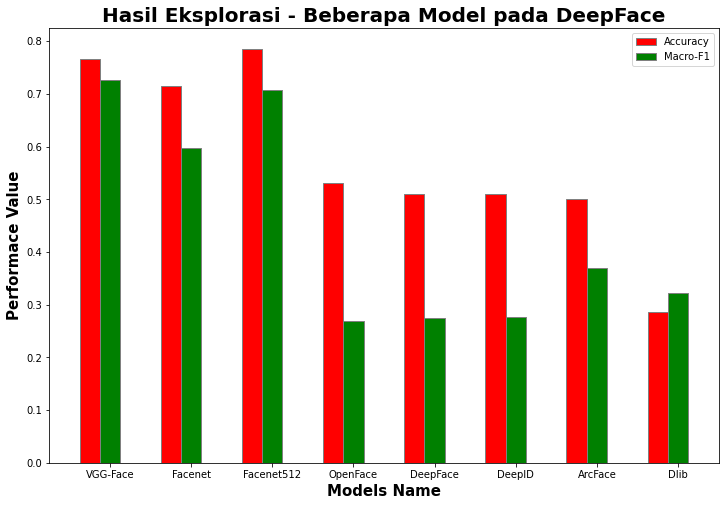

In [ ]:
# Pengaturan lebar dari bar chart
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
 
# Pengaturan dari nilai akurasi dan macro f1 yang akan ditampilkan
index = 0
acc = []
macro_f1 = []
for nama_model in list_models:
  acc.append(hasil_recognition[index][1])
  macro_f1.append(hasil_recognition[index][2])
  index = index + 1
 
# Pengaturan posisi dari setiap bar pada sumbu X
br1 = np.arange(len(acc))
br2 = [x + barWidth for x in br1]
 
# Membuat plot
plt.bar(br1, acc, color ='r', width = barWidth, edgecolor ='grey', label ='Accuracy')
plt.bar(br2, macro_f1, color ='g', width = barWidth, edgecolor ='grey', label ='Macro-F1')
 
# Penambahan informasi pada setiap sumbu
plt.xlabel('Models Name', fontweight ='bold', fontsize = 15)
plt.ylabel('Performace Value', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(acc))], list_models)
 
plt.legend()
plt.title("Hasil Eksplorasi - Beberapa Model pada DeepFace", fontweight ='bold', fontsize = 20)
plt.show()


## **Tahapan 9. Percobaan Kedua dari Strategi Eksperimen dengan DeepFace**
Proses percobaan kedua dilakukan dengan fokus pencarian teknik perhitungan jarak (distance_matrice) terbaik yang bisa digunakan dalam arsitektur DeepFace. Yang mana berdasarkan panduan penggunaan library DeepFace terdapat beberapa teknik pengukuran similaritas ataupun jarak data seperti Cosine Similarity, Euclidean Distance dan Euclidean Distance dengan penerapan L2.
<br><br>
Selain itu, juga digunakan model terbaik dari hasil percobaan pertama yang mana diperoleh dua model yang dianggap lebih unggul dari pada model lainnya, yaitu VGG-Face dan Facenet512.

In [ ]:
# Setting detector_backend : opencv
list_models = ["VGG-Face", "Facenet512"]
matriks_jarak = ["cosine", "euclidean", "euclidean_l2"]
hasil_recognition2 = []

for nama_model in list_models:
  for nama_matrik in matriks_jarak:
    hasil = deepface_apply(nama_model, nama_matrik, "opencv")
    hasil_recognition2.append(hasil)

vgg_face_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/vgg_face_weights.h5
To: /root/.deepface/weights/vgg_face_weights.h5
100%|██████████| 580M/580M [01:44<00:00, 5.54MB/s]


Representations stored in  /content/db_aug_proses / representations_vgg_face.pkl  file. Please delete this file when you add new identities in your database.
find function lasts  164.39395451545715  seconds
There are  168  representations found in  representations_vgg_face.pkl
find function lasts  0.3950924873352051  seconds
There are  168  representations found in  representations_vgg_face.pkl
find function lasts  2.473590850830078  seconds
There are  168  representations found in  representations_vgg_face.pkl
find function lasts  0.6588218212127686  seconds
There are  168  representations found in  representations_vgg_face.pkl
find function lasts  1.2530243396759033  seconds
There are  168  representations found in  representations_vgg_face.pkl
find function lasts  0.3497352600097656  seconds
There are  168  representations found in  representations_vgg_face.pkl
find function lasts  0.48551177978515625  seconds
There are  168  representations found in  representations_vgg_face.pkl
fi

Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facenet512_weights.h5
To: /root/.deepface/weights/facenet512_weights.h5
100%|██████████| 95.0M/95.0M [00:27<00:00, 3.43MB/s]


Representations stored in  /content/db_aug_proses / representations_facenet512.pkl  file. Please delete this file when you add new identities in your database.
find function lasts  70.61367416381836  seconds
There are  168  representations found in  representations_facenet512.pkl
find function lasts  0.18343281745910645  seconds
There are  168  representations found in  representations_facenet512.pkl
find function lasts  2.1138737201690674  seconds
There are  168  representations found in  representations_facenet512.pkl
find function lasts  0.4505882263183594  seconds
There are  168  representations found in  representations_facenet512.pkl
find function lasts  1.085317850112915  seconds
There are  168  representations found in  representations_facenet512.pkl
find function lasts  0.1571645736694336  seconds
There are  168  representations found in  representations_facenet512.pkl
find function lasts  0.28472042083740234  seconds
There are  168  representations found in  representations_f

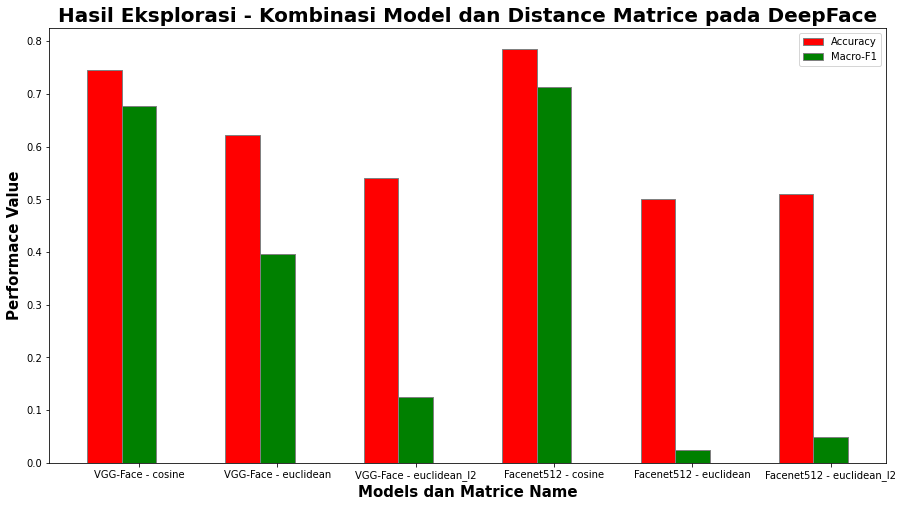

In [ ]:
# Pengaturan dari label sumbu x, nilai akurasi dan macro f1 yang akan ditampilkan
index = 0
acc = []
macro_f1 = []
label_x = []
for nama_model in list_models:
  for nama_matrik in matriks_jarak:
    label_x.append(nama_model+" - "+nama_matrik)
    acc.append(hasil_recognition2[index][1])
    macro_f1.append(hasil_recognition2[index][2])
    index = index + 1

# Pengaturan lebar dari bar chart
barWidth = 0.25
fig = plt.subplots(figsize =(15, 8))

# Pengaturan posisi dari setiap bar pada sumbu X
br1 = np.arange(len(acc))
br2 = [x + barWidth for x in br1]
 
# Membuat plot
plt.bar(br1, acc, color ='r', width = barWidth, edgecolor ='grey', label ='Accuracy')
plt.bar(br2, macro_f1, color ='g', width = barWidth, edgecolor ='grey', label ='Macro-F1')
 
# Penambahan informasi pada setiap sumbu
plt.xlabel('Models dan Matrice Name', fontweight ='bold', fontsize = 15)
plt.ylabel('Performace Value', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(acc))], label_x)
 
plt.legend()
plt.title("Hasil Eksplorasi - Kombinasi Model dan Distance Matrice pada DeepFace", fontweight ='bold', fontsize = 20)
plt.show()


## **Tahapan 10. Percobaan Ketiga dari Strategi Eksperimen dengan DeepFace**
Proses percobaan ketiga dilakukan dengan fokus pencarian pada detector backend terbaik yang bisa digunakan dalam arsitektur DeepFace. Yang mana berdasarkan panduan penggunaan library DeepFace terdapat beberapa detector backend yang bisa digunakan seperti OpenCV, SSD, Dlib, MTCNN, RetinaFace, dan MediaPipe.
<br><br>
Selain itu, juga digunakan model terbaik dari hasil percobaan kedua yang mana diperoleh dua kombinasi yang dianggap lebih unggul dari pada kombinasi lainnya, yaitu VGG-Face+Cosine dan Facenet512+Cosine.

In [ ]:
!pip install mediapipe==0.8.9.1
import mediapipe

# Setting matriks_jarak : cosine
list_models = ["VGG-Face", "Facenet512"]
list_backends = ['opencv', 'ssd', 'dlib', 'mtcnn', 'retinaface', 'mediapipe']
hasil_recognition3 = []

for nama_model in list_models:
  for nama_backend in list_backends:
    hasil = deepface_apply(nama_model, "cosine", nama_backend)
    hasil_recognition3.append(hasil)

There are  168  representations found in  representations_vgg_face.pkl
find function lasts  0.5018067359924316  seconds
There are  168  representations found in  representations_vgg_face.pkl
find function lasts  0.39914369583129883  seconds
There are  168  representations found in  representations_vgg_face.pkl
find function lasts  3.975480318069458  seconds
There are  168  representations found in  representations_vgg_face.pkl
find function lasts  1.3121287822723389  seconds
There are  168  representations found in  representations_vgg_face.pkl
find function lasts  2.780127763748169  seconds
There are  168  representations found in  representations_vgg_face.pkl
find function lasts  1.0498156547546387  seconds
There are  168  representations found in  representations_vgg_face.pkl
find function lasts  1.0593738555908203  seconds
There are  168  representations found in  representations_vgg_face.pkl
find function lasts  1.0996320247650146  seconds
There are  168  representations found in 

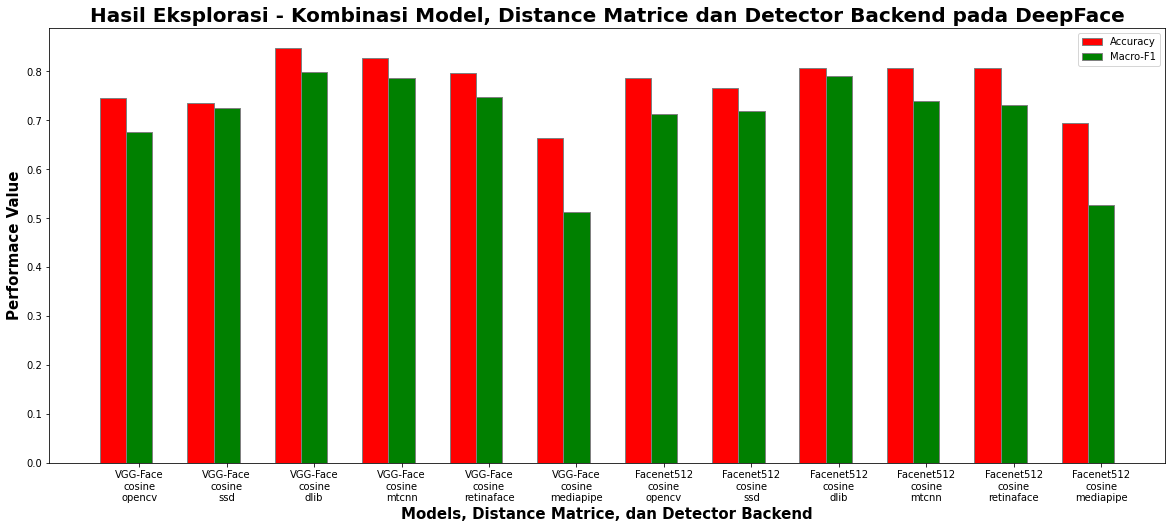

In [ ]:
# Pengaturan dari label sumbu x, nilai akurasi dan macro f1 yang akan ditampilkan
index = 0
acc = []
macro_f1 = []
label_x = []
for nama_model in list_models:
  for nama_backend in list_backends:
    label_x.append(nama_model+"\ncosine\n"+nama_backend)
    acc.append(hasil_recognition3[index][1])
    macro_f1.append(hasil_recognition3[index][2])
    index = index + 1

# Pengaturan lebar dari bar chart
barWidth = 0.3
fig = plt.subplots(figsize =(20, 8))

# Pengaturan posisi dari setiap bar pada sumbu X
br1 = np.arange(len(acc))
br2 = [x + barWidth for x in br1]
 
# Membuat plot
plt.bar(br1, acc, color ='r', width = barWidth, edgecolor ='grey', label ='Accuracy')
plt.bar(br2, macro_f1, color ='g', width = barWidth, edgecolor ='grey', label ='Macro-F1')
 
# Penambahan informasi pada setiap sumbu
plt.xlabel('Models, Distance Matrice, dan Detector Backend', fontweight ='bold', fontsize = 15)
plt.ylabel('Performace Value', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(acc))], label_x)
 
plt.legend()
plt.title("Hasil Eksplorasi - Kombinasi Model, Distance Matrice dan Detector Backend pada DeepFace", fontweight ='bold', fontsize = 20)
plt.show()


## **Tahapan 11. Percobaan Keempat dari Strategi Eksperimen dengan DeepFace**
Percobaan dengan beberapa nilai distance threshold yang berbeda, dengan setting parameter DeepFace yaitu: (i) Model = VGG-Face; (ii) distance_matrice = cosine; dan (iii) detector_backend = dlib. Selain itu, akan dicoba nilai distance threshold dari rencang 0,05 hingga 0,3.

In [ ]:
# Fungsi eksplorasi untuk mencari nilai distance threshold terbaik
def deepface_applyThreshold(nama_model, matriks_jarak, detector, threshold_value):
  hasil_eksperimen = []
  label_actual = []
  label_predict = []

  path_db = '/content/db_wajah_test/'
  for path, subdirs, files in os.walk(path_db):
    for name in files :
      test_image = path_db+name
      hasil_deepface = DeepFace.find(img_path = test_image, db_path = "/content/db_aug_proses", enforce_detection=False, prog_bar=True, model_name=nama_model, distance_metric=matriks_jarak, detector_backend=detector)

      dist_threshold = threshold_value
      label_find = []
      for hasil_path,dist_value in zip(hasil_deepface.iloc[:, 0],hasil_deepface.iloc[:, 1]) :
        if dist_value < dist_threshold :
          nama_file = hasil_path.split("/")
          nama_anggota = nama_file[3].split("-")
          label_find.append(nama_anggota[0])

      if len(label_find) > 0 :
        label_predict.append(stats.mode(label_find)[0][0])
      else :
        label_predict.append("Non Anggota Kelas")

      nama_file_actual = test_image.split("/")
      nama_anggota_actual = nama_file_actual[3].split("-")
      if nama_anggota_actual[1] == "AA" :
        temp = nama_anggota_actual[2].split(".")
        label_actual.append(temp[0])
      else :
        label_actual.append("Non Anggota Kelas")
  
  hasil_eksperimen.append(confusion_matrix(label_actual, label_predict, labels=list_label))
  hasil_eksperimen.append(accuracy_score(label_actual, label_predict))
  hasil_eksperimen.append(f1_score(label_actual, label_predict, average='macro')) 
  return hasil_eksperimen

In [ ]:
# Setting model : VGG-Face
# Setting matriks_jarak : cosine
# Setting detector_backend : dlib
threshold_list = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
hasil_recognition4 = []

for threshold_value in threshold_list:
  hasil = deepface_applyThreshold("VGG-Face", "cosine", "dlib", threshold_value)
  hasil_recognition4.append(hasil)

vgg_face_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/vgg_face_weights.h5
To: /root/.deepface/weights/vgg_face_weights.h5
100%|██████████| 580M/580M [00:45<00:00, 12.9MB/s]


shape_predictor_5_face_landmarks.dat.bz2 is going to be downloaded


Downloading...
From: http://dlib.net/files/shape_predictor_5_face_landmarks.dat.bz2
To: /root/.deepface/weights/shape_predictor_5_face_landmarks.dat.bz2
100%|██████████| 5.71M/5.71M [00:00<00:00, 5.81MB/s]


Representations stored in  /content/db_aug_proses / representations_vgg_face.pkl  file. Please delete this file when you add new identities in your database.
find function lasts  124.32649254798889  seconds
There are  168  representations found in  representations_vgg_face.pkl
find function lasts  0.48693418502807617  seconds
There are  168  representations found in  representations_vgg_face.pkl
find function lasts  6.5879271030426025  seconds
There are  168  representations found in  representations_vgg_face.pkl
find function lasts  1.1818573474884033  seconds
There are  168  representations found in  representations_vgg_face.pkl
find function lasts  1.7784874439239502  seconds
There are  168  representations found in  representations_vgg_face.pkl
find function lasts  0.46846842765808105  seconds
There are  168  representations found in  representations_vgg_face.pkl
find function lasts  0.7212843894958496  seconds
There are  168  representations found in  representations_vgg_face.pkl


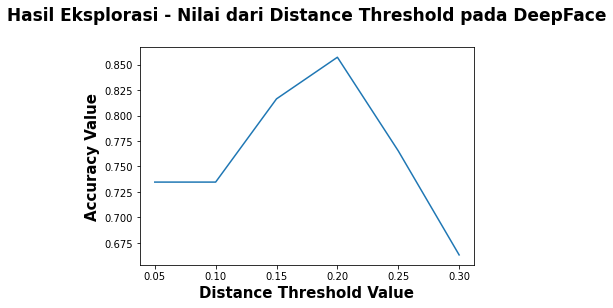

In [ ]:
# Pengaturan dari nilai akurasi yang akan ditampilkan berdasarkan suatu nilai distance threshold
index = 0
acc = []
for threshold_value in threshold_list:
  acc.append(hasil_recognition4[index][1])
  index = index + 1

# Menampilkan hasil perhitungan accuracy pada setiap percobaan nilai distance threshold
plt.plot(threshold_list, acc)
plt.title("Hasil Eksplorasi - Nilai dari Distance Threshold pada DeepFace\n", fontweight ='bold', fontsize = 17)
plt.xlabel('Distance Threshold Value', fontweight ='bold', fontsize = 15)
plt.ylabel('Accuracy Value', fontweight ='bold', fontsize = 15)
plt.show()


## **Tahapan 12. Penampilan Data yang Berhasil dan Gagal Diklasifikasikan**
Pada bagian ini akan ditampilkan beberapa contoh data yang berhasil diklasifikasikan dengan benar dan yang gagal diklasifikasi.

In [ ]:
hasil_eksperimen = []
file_identity = []
label_actual = []
label_predict = []

path_db = '/content/db_wajah_test/'
for path, subdirs, files in os.walk(path_db):
  for name in files :
    test_image = path_db+name
    hasil_deepface = DeepFace.find(img_path = test_image, db_path = "/content/db_aug_proses", enforce_detection=False, prog_bar=True, model_name='VGG-Face', distance_metric='cosine', detector_backend='dlib')
    file_identity.append(test_image)

    dist_threshold = 0.2
    label_find = []
    for hasil_path,dist_value in zip(hasil_deepface.iloc[:, 0],hasil_deepface.iloc[:, 1]) :
      if dist_value < dist_threshold :
        nama_file = hasil_path.split("/")
        nama_anggota = nama_file[3].split("-")
        label_find.append(nama_anggota[0])

    if len(label_find) > 0 :
      label_predict.append(stats.mode(label_find)[0][0])
    else :
      label_predict.append("Non Anggota Kelas")

    nama_file_actual = test_image.split("/")
    nama_anggota_actual = nama_file_actual[3].split("-")
    if nama_anggota_actual[1] == "AA" :
      temp = nama_anggota_actual[2].split(".")
      label_actual.append(temp[0])
    else :
      label_actual.append("Non Anggota Kelas")
  
hasil_eksperimen.append(confusion_matrix(label_actual, label_predict, labels=list_label))
hasil_eksperimen.append(accuracy_score(label_actual, label_predict))
hasil_eksperimen.append(f1_score(label_actual, label_predict, average='macro'))

There are  168  representations found in  representations_vgg_face.pkl
find function lasts  1.5025482177734375  seconds
There are  168  representations found in  representations_vgg_face.pkl
find function lasts  0.8088257312774658  seconds
There are  168  representations found in  representations_vgg_face.pkl
find function lasts  6.713371753692627  seconds
There are  168  representations found in  representations_vgg_face.pkl
find function lasts  1.188786506652832  seconds
There are  168  representations found in  representations_vgg_face.pkl
find function lasts  1.822577714920044  seconds
There are  168  representations found in  representations_vgg_face.pkl
find function lasts  0.46607494354248047  seconds
There are  168  representations found in  representations_vgg_face.pkl
find function lasts  0.7362651824951172  seconds
There are  168  representations found in  representations_vgg_face.pkl
find function lasts  0.6543593406677246  seconds
There are  168  representations found in  

In [ ]:
print("Nilai Akurasi  -> ", hasil_eksperimen[1])
print("Nilai Macro F1 -> ", hasil_eksperimen[2])

Nilai Akurasi  ->  0.8673469387755102
Nilai Macro F1 ->  0.8291005291005291


Actual :  Reza Budiawan   <=>  Predicted :  Reza Budiawan


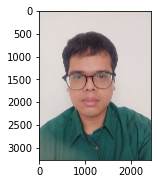

In [ ]:
# Menampilkan contoh data yang benar diklasifikasikan sebagai anggota kelas
index = 0
for nama_label in label_actual:
  if (nama_label != "Non Anggota Kelas") :
    if (nama_label == label_predict[index]) :
      data_wajah_test = io.imread(file_identity[index])
      plot_wajah_test = (np.expand_dims(data_wajah_test, axis=-1)/255.).astype(np.float32)
      plt.figure(figsize=(2,4))
      plt.imshow(np.squeeze(plot_wajah_test), cmap=plt.cm.binary)
      print("Actual : ",nama_label,"  <=>  Predicted : ",label_predict[index])
      break
  index = index + 1

Actual :  Non Anggota Kelas   <=>  Predicted :  Non Anggota Kelas


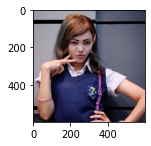

In [ ]:
# Menampilkan contoh data yang benar diklasifikasikan sebagai non anggota kelas
index = 0
for nama_label in label_actual:
  if (nama_label == "Non Anggota Kelas") :
    if (nama_label == label_predict[index]) :
      data_wajah_test = io.imread(file_identity[index])
      plot_wajah_test = (np.expand_dims(data_wajah_test, axis=-1)/255.).astype(np.float32)
      plt.figure(figsize=(2,4))
      plt.imshow(np.squeeze(plot_wajah_test), cmap=plt.cm.binary)
      print("Actual : ",nama_label,"  <=>  Predicted : ",label_predict[index])
      break
  index = index + 1

Actual :  Lathifah Arief   <=>  Predicted :  Non Anggota Kelas


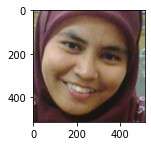

In [ ]:
# Menampilkan contoh data yang salah diklasifikasikan sebagai non anggota kelas yang seharusnya anggota kelas
index = 0
for nama_label in label_actual:
  if (label_predict[index] == "Non Anggota Kelas") :
    if (nama_label != label_predict[index]) :
      data_wajah_test = io.imread(file_identity[index])
      plot_wajah_test = (np.expand_dims(data_wajah_test, axis=-1)/255.).astype(np.float32)
      plt.figure(figsize=(2,4))
      plt.imshow(np.squeeze(plot_wajah_test), cmap=plt.cm.binary)
      print("Actual : ",nama_label,"  <=>  Predicted : ",label_predict[index])
      break
  index = index + 1

Actual :  Non Anggota Kelas   <=>  Predicted :  Leni Fitriani


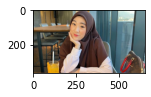

In [ ]:
# Menampilkan contoh data yang salah diklasifikasikan sebagai anggota kelas yang seharusnya non anggota kelas
index = 0
for nama_label in label_actual:
  if (nama_label == "Non Anggota Kelas") :
    if (nama_label != label_predict[index]) :
      data_wajah_test = io.imread(file_identity[index])
      plot_wajah_test = (np.expand_dims(data_wajah_test, axis=-1)/255.).astype(np.float32)
      plt.figure(figsize=(2,4))
      plt.imshow(np.squeeze(plot_wajah_test), cmap=plt.cm.binary)
      print("Actual : ",nama_label,"  <=>  Predicted : ",label_predict[index])
      break
  index = index + 1